CSCI 5636 Homework 2

Luke Meszar

Use a Chebyshev method to solve the second order ordinary differential equation

$$ u''(t) + a u'(t) + b u(t) = f(t) $$

from $t=0$ to $t=1$ with initial conditions $u(0) = 1$ and $u'(0) = 0$.

1. Do a grid convergence study to test the accuracy of your method.
* Setting $f(t)=0$, experiment with the values $a$ and $b$ to identify two regimes with qualitatively different dynamics.

In [202]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import itertools
plt.style.use('ggplot')

In [ ]:
def vander_chebyshev(x, n=None):
    if n is None:
        n = len(x)
    T = np.ones((len(x), n))
    if n > 1:
        T[:,1] = x
    for k in range(2,n):
        T[:,k] = 2 * x * T[:,k-1] - T[:,k-2]
    return T

def chebeval(z, n=None):
    """Build matrices to evaluate the n-term Chebyshev expansion and its derivatives at point(s) z"""
    z = np.array(z, ndmin=1)
    if n is None:
        n = len(z)
    Tz = vander_chebyshev(z, n)
    dTz = np.zeros_like(Tz)
    dTz[:,1] = 1
    dTz[:,2] = 4*z
    ddTz = np.zeros_like(Tz)
    ddTz[:,2] = 4
    for n in range(3,n):
        dTz[:,n]  = n * (2*Tz[:,n-1] + dTz[:,n-2]/(n-2))
        ddTz[:,n] = n * (2*dTz[:,n-1] + ddTz[:,n-2]/(n-2))
    return [Tz, dTz, ddTz]

def cosspace(a, b, n=50):
    return (a + b)/2 + (b - a)/2 * (np.cos(np.linspace(-np.pi, 0, n)))

This is essentially the same laplacian_cheb as the one in the FDHighOrder notebook. However, since we are working on the interval $[0,1]$ instead of $[-1,1]$, we have to use the transofmation function $t(x) = 2x - 1$. This takes the points on $[0,1]$ onto the interval $[-1,1]$ since $t(0) = -1$ and $t(1) = 1$. Then to compute the derivatives, we use the chain rule. So
$$T_n'(2x-1) = 2(T_n'(2x-1))$$
and since we have already calculated $T_n'(2x-1)$ in the chebeval function, all we need to do is multiply by two. Like, to calculate the second derivative, we get
$$T_n''(2x-1) = 2(T_n'(2x-1))' = 4T_n''(2x-1).$$
Again, since we have already calculated $T_n''(2x-1)$ in the chebeval function, all we need to do is multiply by four.

4.77395900589e-15


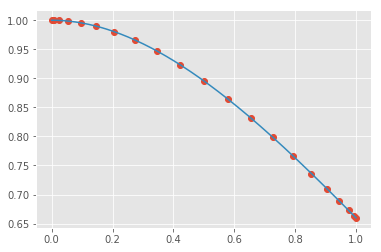

In [187]:
def laplacian_cheb(n, rhsfunc, a, b):
    x = cosspace(0, 1, n+1)  # n+1 points is n "elements"
    T = chebeval(x)
    T = chebeval(2*x - 1)
    T[1]  = 2*T[1]
    T[2] = 4*T[2]
    L = T[2] + a*T[1] + b*T[0]
    L[0] = T[0][0] #implementing boundary condition u(0) = 1 on the L side
    L[-1] = T[1][0] #implementing boundary condition u'(0) = 0 on the L side
    rhs = rhsfunc(x)
    rhs[0] = 1 #implementing boundary condition u(0) = 1 on the RHS side
    rhs[-1] = 0 #implementing boundary condition u'(0) = 0 on the RHS side
    return x, L @ np.linalg.inv(T[0]), rhs
x, L, rhs = laplacian_cheb(20, lambda x: 0*x, 1, 1)
u = np.linalg.solve(L, rhs)

plt.plot(x,u,  'o')
xx = np.linspace(0,1,200)
#the exact solution to the ODE u''(x) + u'(x) + u(x) = 0 was found using Mathematica
plt.plot(xx,1/3*np.e**(-xx/2) * (3*np.cos((np.sqrt(3)*xx)/2) + np.sqrt(3)*np.sin((np.sqrt(3)*xx)/2)))

1.44328993201e-14


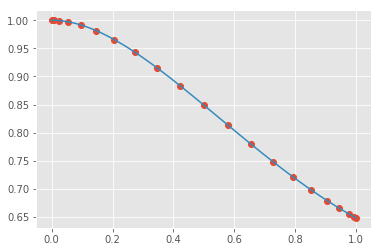

In [175]:
x, L, rhs = laplacian_cheb(20, lambda x: x**2, 3, 2)
u = np.linalg.solve(L, rhs)

plt.plot(x,u,  'o')
xx = np.linspace(0,1,200)
#the exact solution to the ODE u''(x) + 3u'(x) + 2u(x) = x^2 was found using Mathematica
plt.plot(xx,1/4*np.e**(-2*xx)*(-3+7*np.e**(2*xx)-6*np.e**(2*xx)*xx+2*np.e**(2*xx)*xx**2))
print(np.linalg.norm(u-(1/4*np.e**(-2*x)*(-3+7*np.e**(2*x)-6*np.e**(2*x)*x+2*np.e**(2*x)*x**2)), np.inf))

# Grid Refinement Study

Below we conduct a grid convergence study using the ODE $$u''(x) + 3u'(x) + 2u(x) = x^2$$ with initial conditions $u(0) = 1$ and $u'(0) = 0$. This has an analytic solution of $u(x) = \frac{1}{4} e^{-2 x} \left(2 e^{2 x} x^2-6 e^{2 x} x+7 e^{2 x}-3\right)$ obtained from Mathematica.

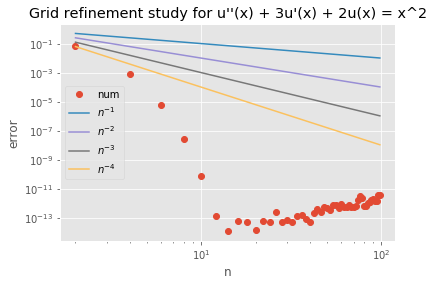

In [226]:
def grid_refinement_study(n_list, discretizer, forcing, a,b, exact_sol):
    errors = []
    for n in n_list:
        x, L, rhs = laplacian_cheb(n, forcing, a, b)
        u = np.linalg.solve(L, rhs)
        errors.append(np.linalg.norm(u - exact_sol(x), np.inf))
    return errors

n_list = np.arange(2,100,2)
def ex_sol(x):
    return 1/4*np.e**(-2*x)*(-3+7*np.e**(2*x)-6*np.e**(2*x)*x+2*np.e**(2*x)*x**2)
errors = grid_refinement_study(n_list, laplacian_cheb, lambda x: x**2, 3,2, ex_sol)
plt.figure()
plt.loglog(n_list, errors, 'o', label='num')
for p in range(1,5):
    plt.loglog(n_list, 1/n_list**(p), label='$n^{-%d}$'%p)
plt.xlabel('n')
plt.ylabel('error')
plt.title("Grid refinement study for u''(x) + 3u'(x) + 2u(x) = x^2")
plt.legend(loc='center left');

We see that we get convergence that is faster than any polynomial function up until 14 points. Then the accuracy gets worse on average from there on. 

# Experimenting with coefficients

A second order linear ODE with constant coefficients has solutions which correspond to roots of the following characterstic equation in $r$:
$$r^2 + ar + b = 0$$
since we are fixing the coefficient on the $u''(x)$ term to be $1$.

This equation has solutions as
$$r_1,r_2 = \frac{-a\pm \sqrt{a^2 - 4b}}{2}.$$

If $a^2 < 4b$, then the system is considered underdamped. 

If $a^2 > 4b$, then the system is considered overdamped. 

If $a^2 = 4b$, then the system is considered critcally damped. 

We choose the coefficient pairs $(2,60)$ and $(4,10)$ to be the underdamped system, the pairs $(15,2)$ and $(5,2)$ for the overdamped system, and the pair $(2,1)$ for the critically damped system. 

The underdamped case corresponds to a harmonic oscillator under the effects of friction causing it slow down to an equillibrium.

The overdamped case means the friction is so large that the oscillator can't oscillate. 

Like the overdamped case, the critical damping case means no oscillation. However, this case forces the system to an equillibrium the fastest. 

Below, we see a plot of the solutions of the various systems.

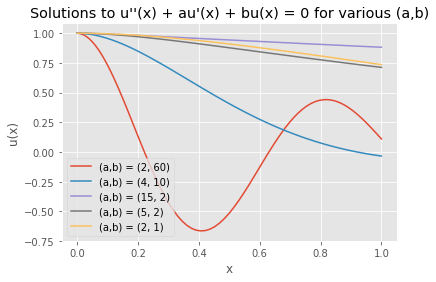

In [236]:
coeff_list = [(2,60),(4,10), (15,2),(5,2),(2,1)]

for coeffs in coeff_list:
    a, b = coeffs[0], coeffs[1]
    x, L, rhs = laplacian_cheb(100, lambda x: 0*x, a, b)
    u = np.linalg.solve(L, rhs)
    plt.plot(x,u, label='(a,b) = ' + str(coeffs))
plt.title("Solutions to u''(x) + au'(x) + bu(x) = 0 for various (a,b)")
plt.ylabel('u(x)')
plt.xlabel('x')
plt.legend(loc='lower left')